In [2]:
import sys
sys.path.append("../../")

from models.message import Message
from models.run import Run
from models.duck_basemodel import DuckDBModel
DuckDBModel.initialize_db('/home/hessel/code/master-thesis/databases/fraud-prod.db')  # Use ':memory:' for in-memory database

In [3]:
[(x.id, x.model_name) 
 for x in Run.list_all() 
 if len(x.get_messages()) > 500]

[(12, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (16, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (30, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (36, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (38, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (41, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (50, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (56, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (85, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (99, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (101, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (109, 'llama-3.2-3b-instruct-q8_0.gguf'),
 (126, 'Phi-3.5-mini-instruct-Q8_0'),
 (130, 'Hermes-3-Llama-3.1-8B.Q4_K_M.gguf'),
 (131, 'gemma-2-9b-it-Q4_K_M.gguf'),
 (133, 'Mistral-Nemo-Instruct-2407-Q4_K_M.gguf'),
 (134, 'gemma-2-9b-it-Q4_K_M.gguf'),
 (137, 'smollm2-1.7b-instruct-q4_k_m.gguf'),
 (139, 'Qwen2.5-7B-Instruct.Q4_K_M.gguf'),
 (141, 'Meta-Llama-3.1-8B-Instruct-Q4_K_M.gguf'),
 (150, 'svm'),
 (151, 'svm'),
 (153, 'rf')]

In [13]:
run = Run.get(id=116)
# Create visualization
run.formatted_name()


'llama-3.2-3b'

/tmp/ipykernel_115900/949314089.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.5)


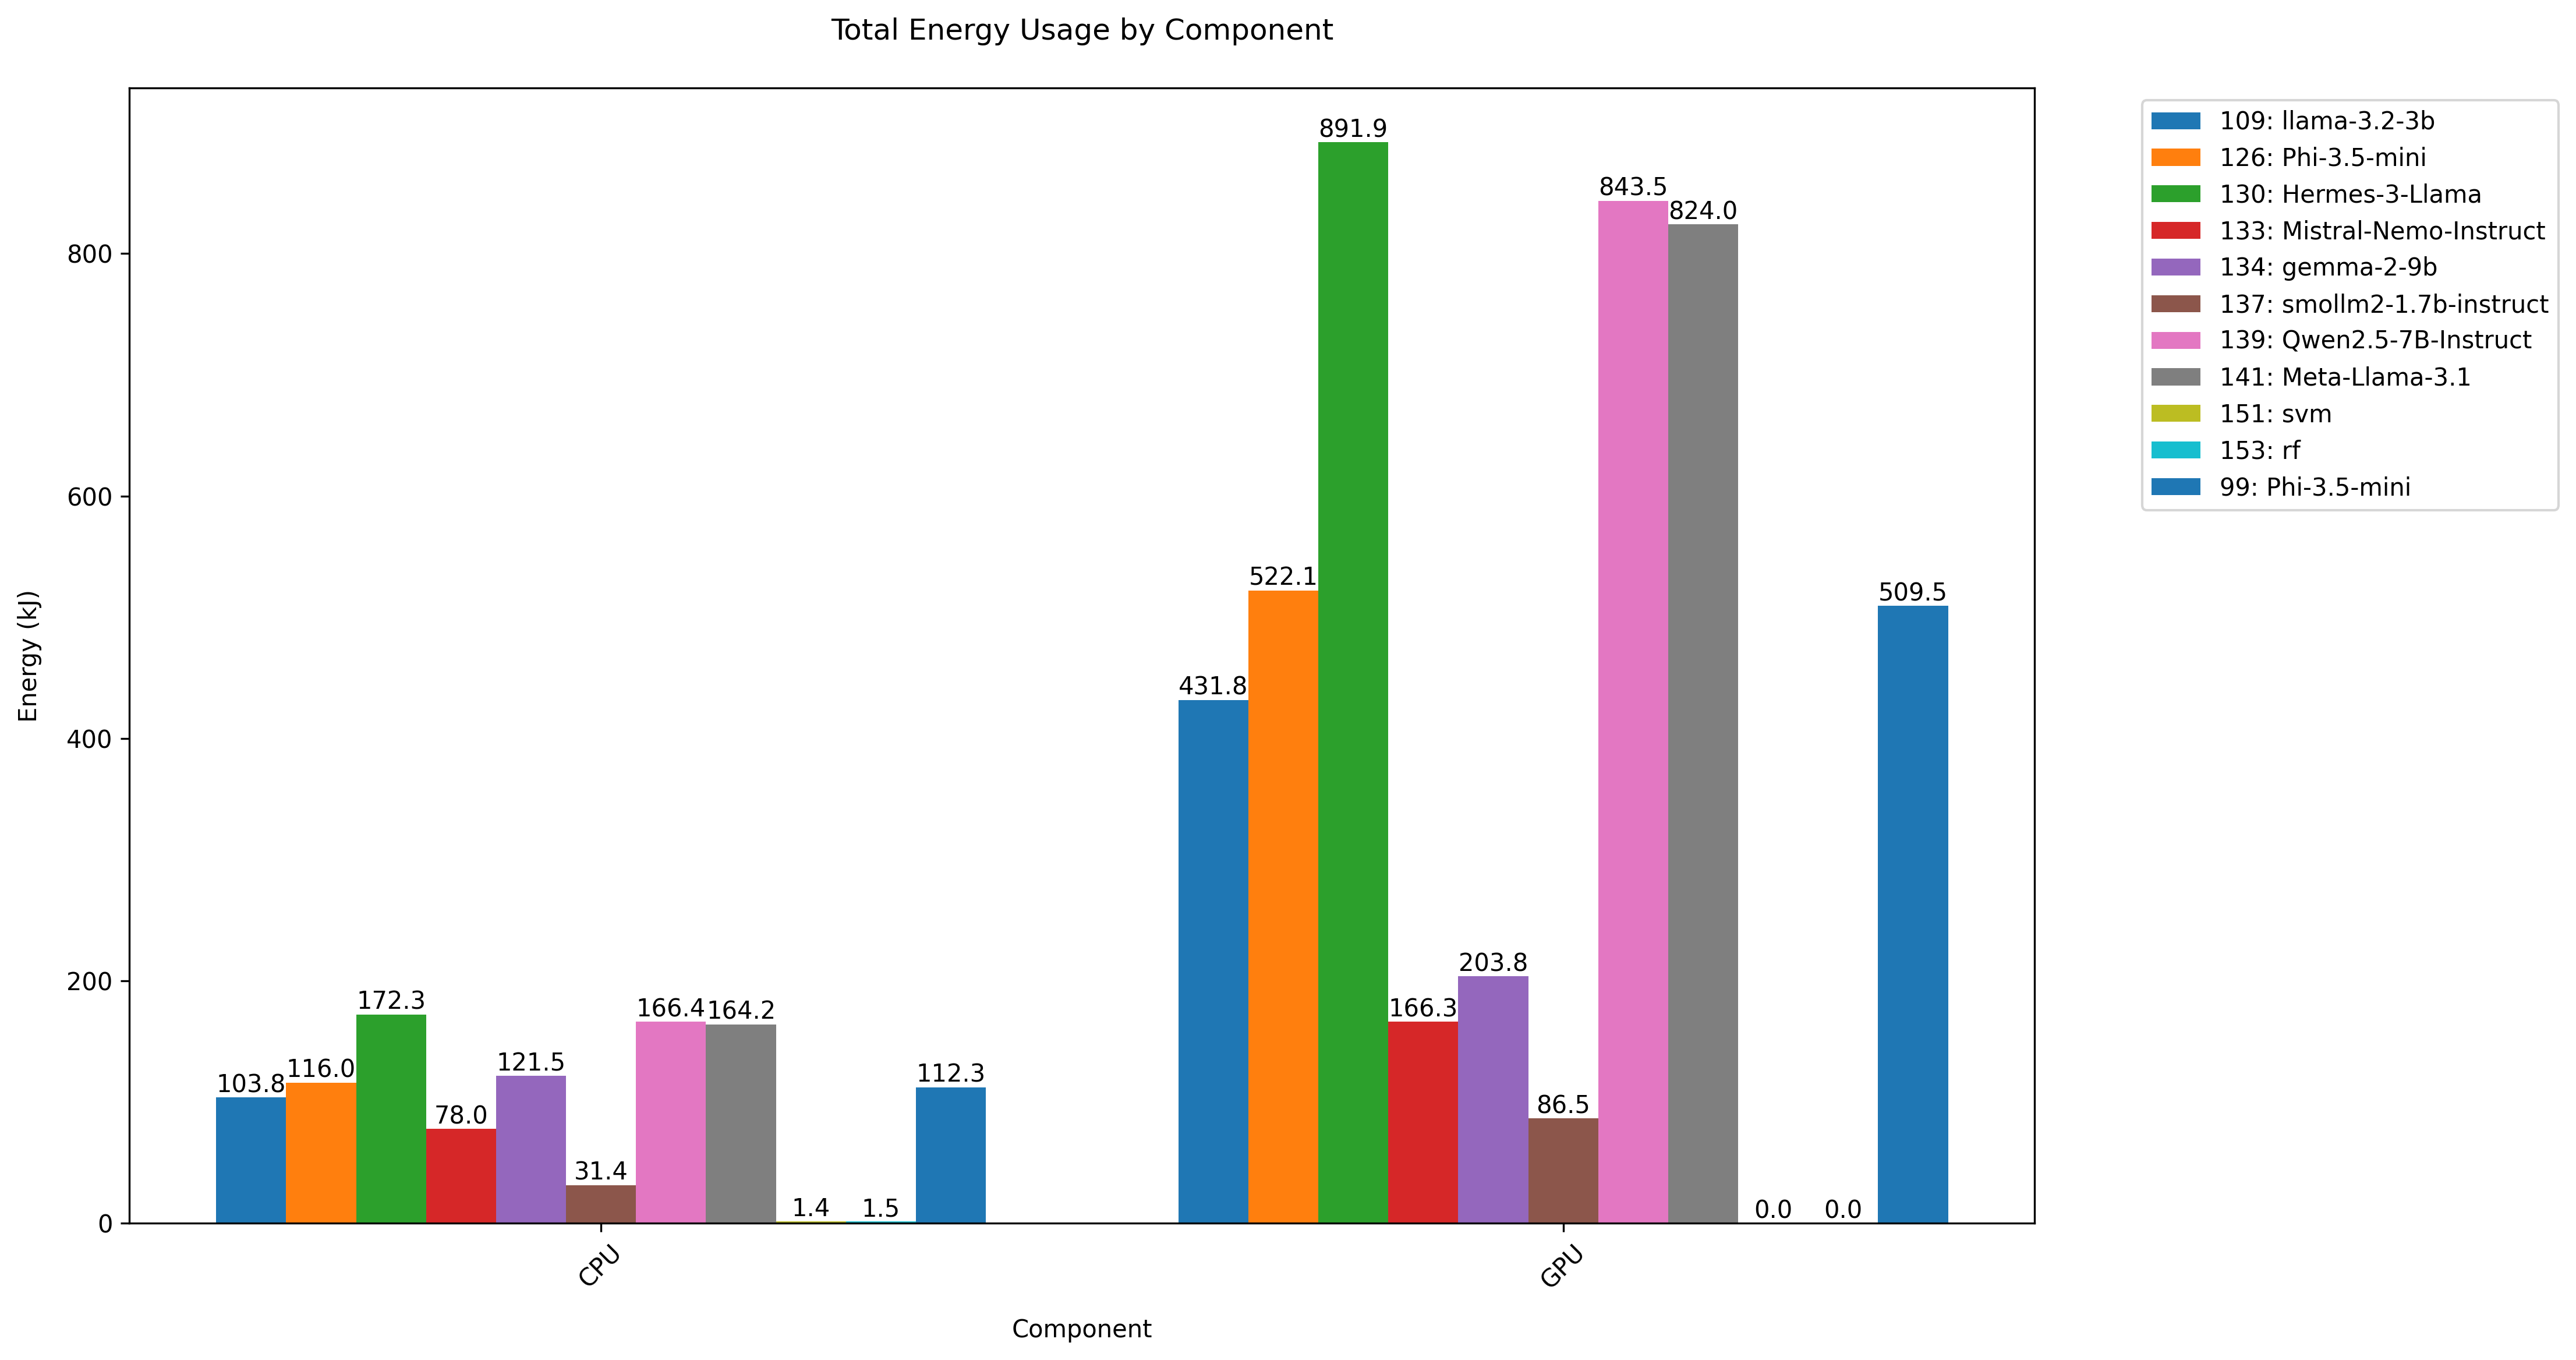

/tmp/ipykernel_115900/949314089.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.5)


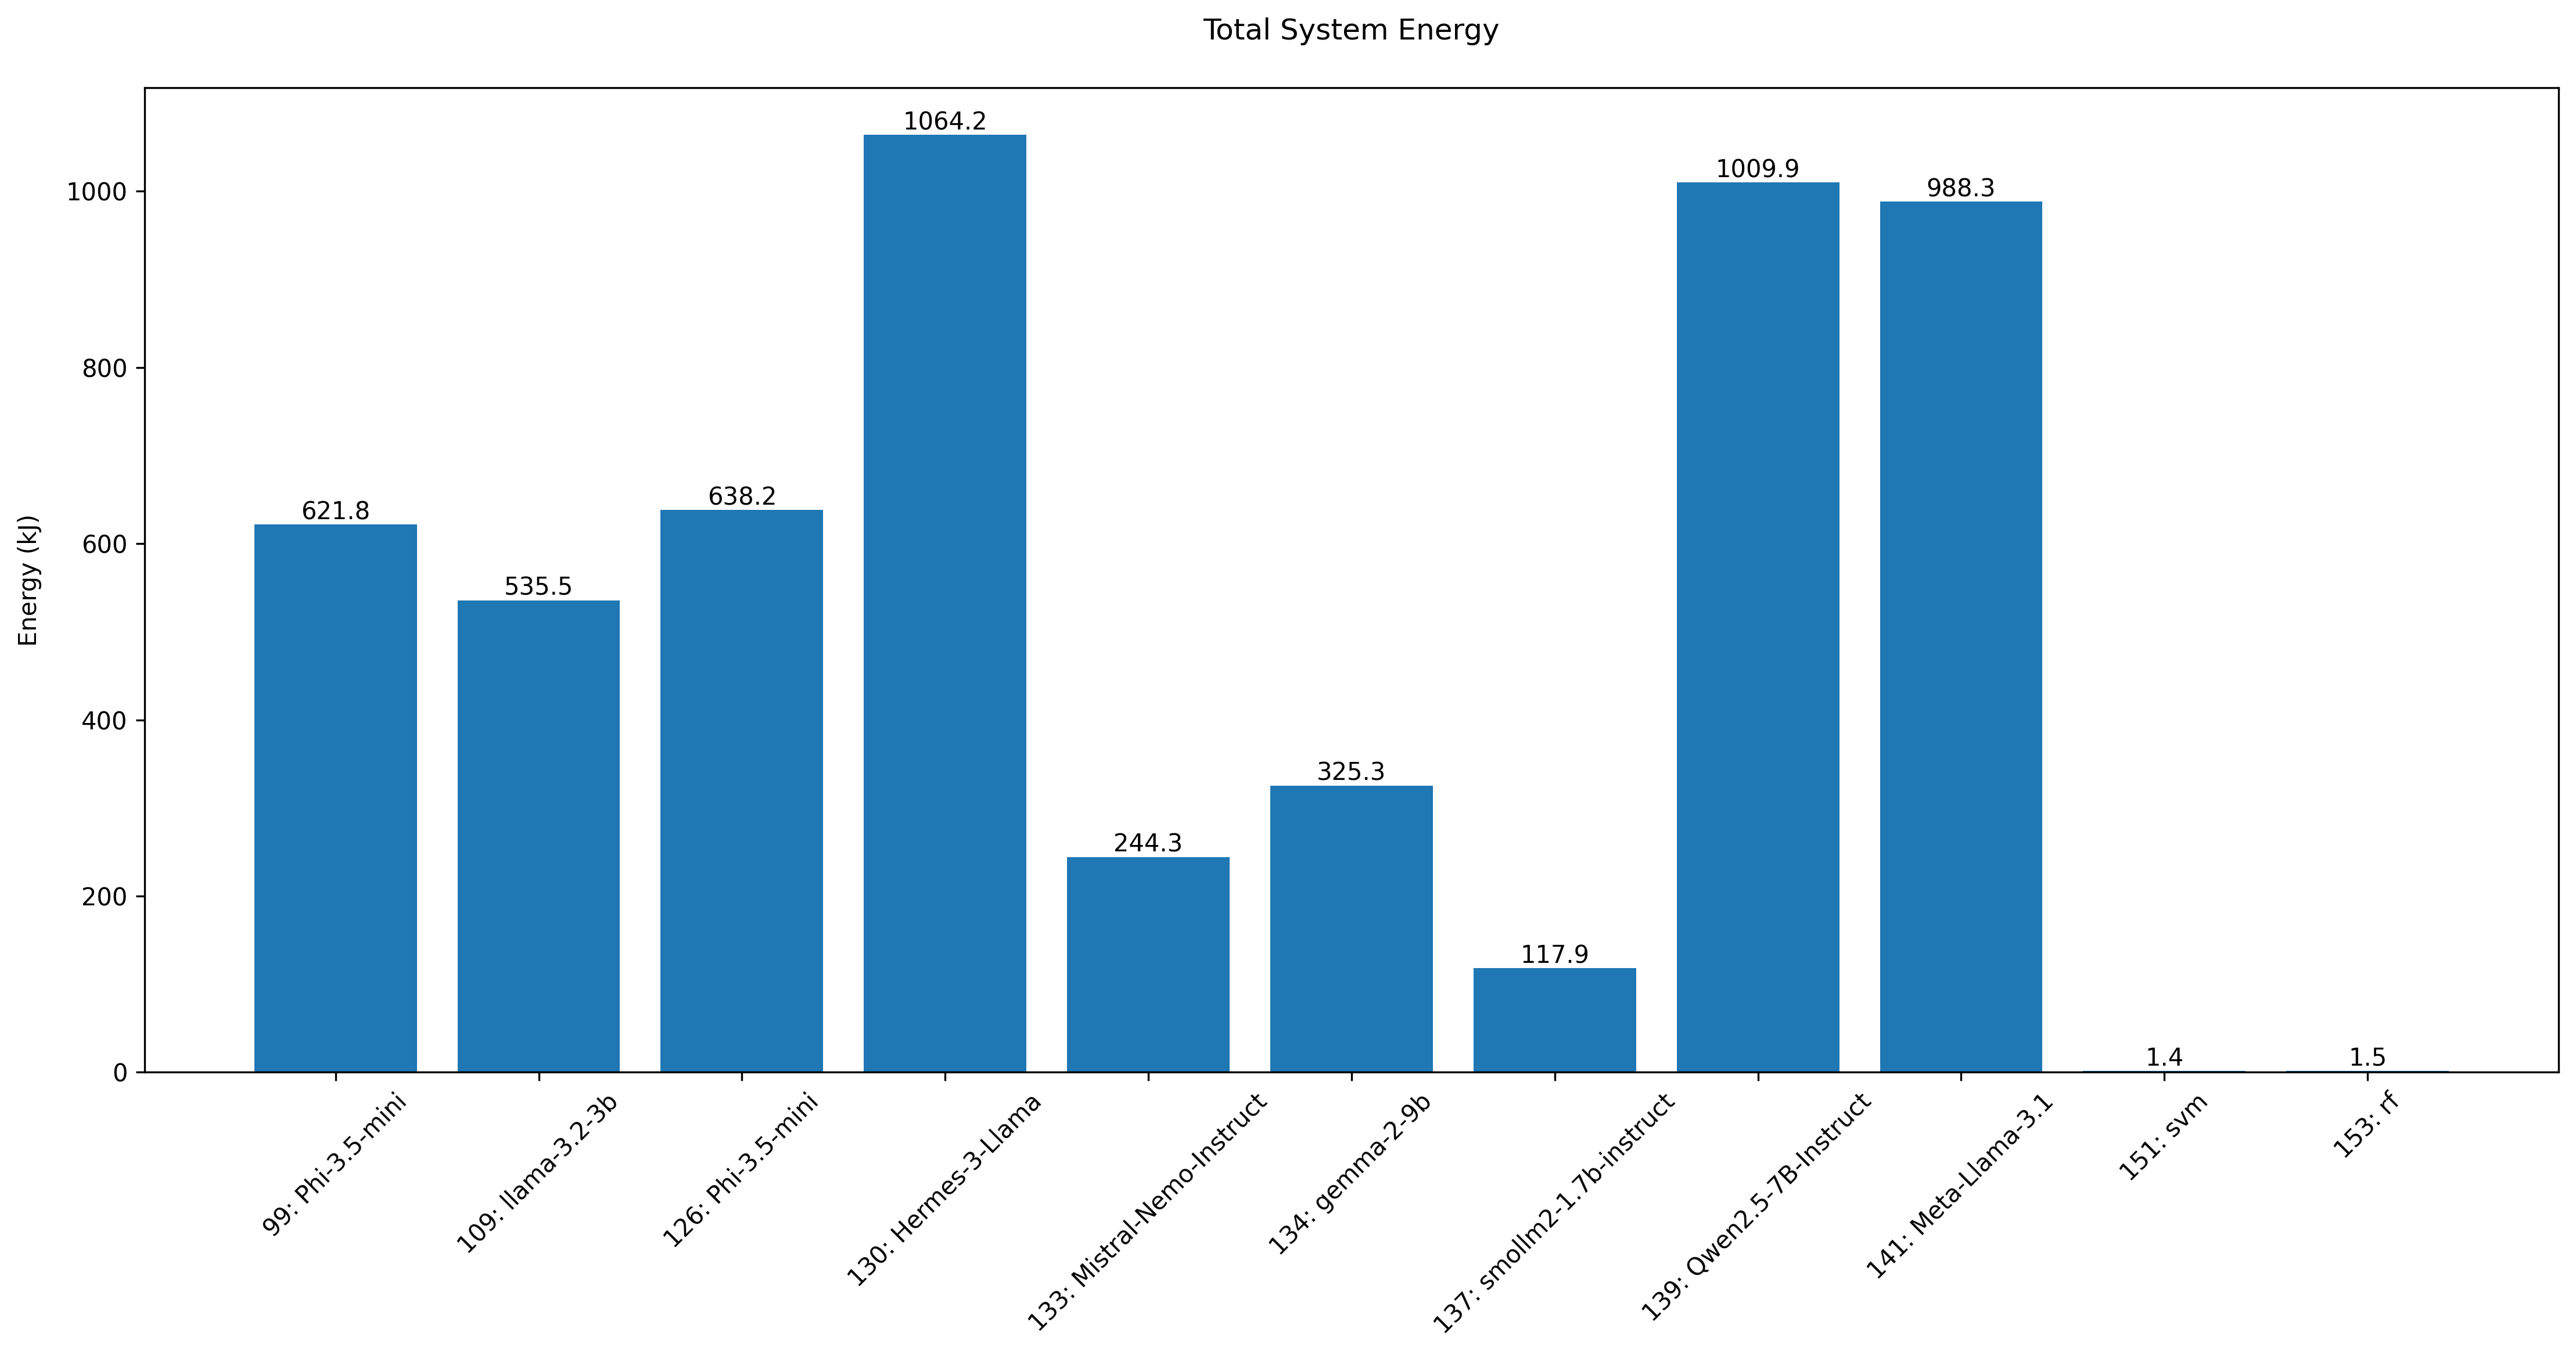

/tmp/ipykernel_115900/949314089.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(left[idx] + width/2,
/tmp/ipykernel_115900/949314089.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.5)


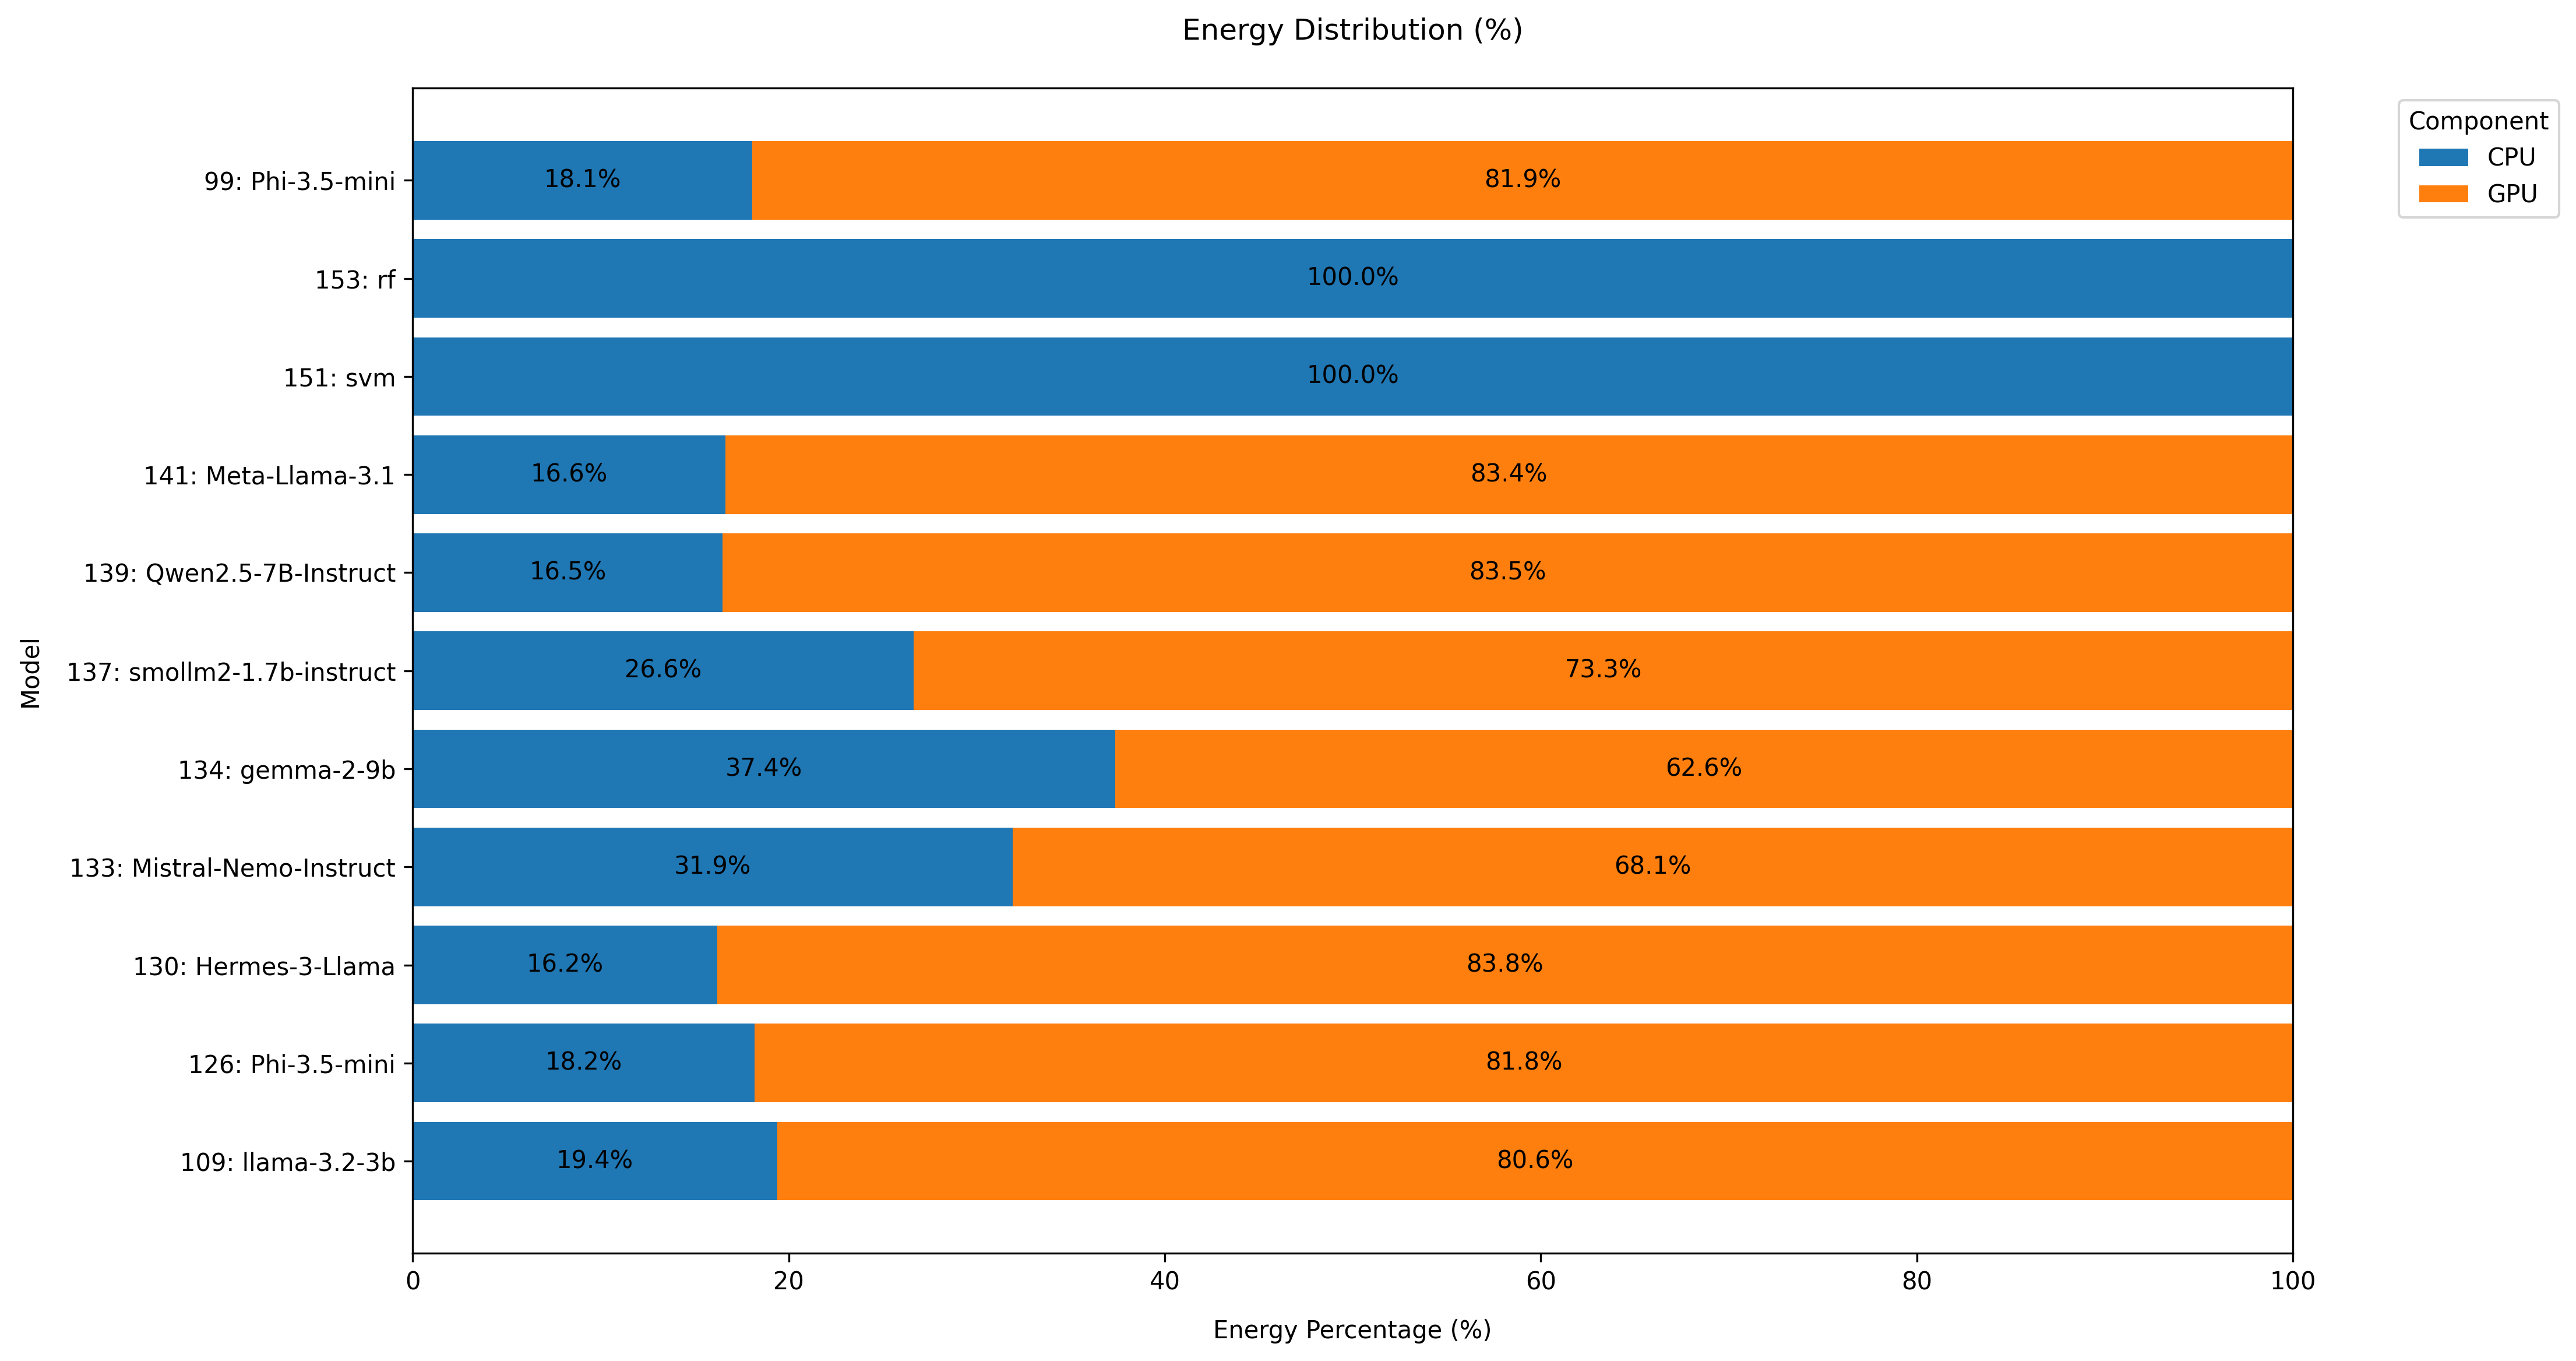

/tmp/ipykernel_115900/949314089.py:112: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.5)


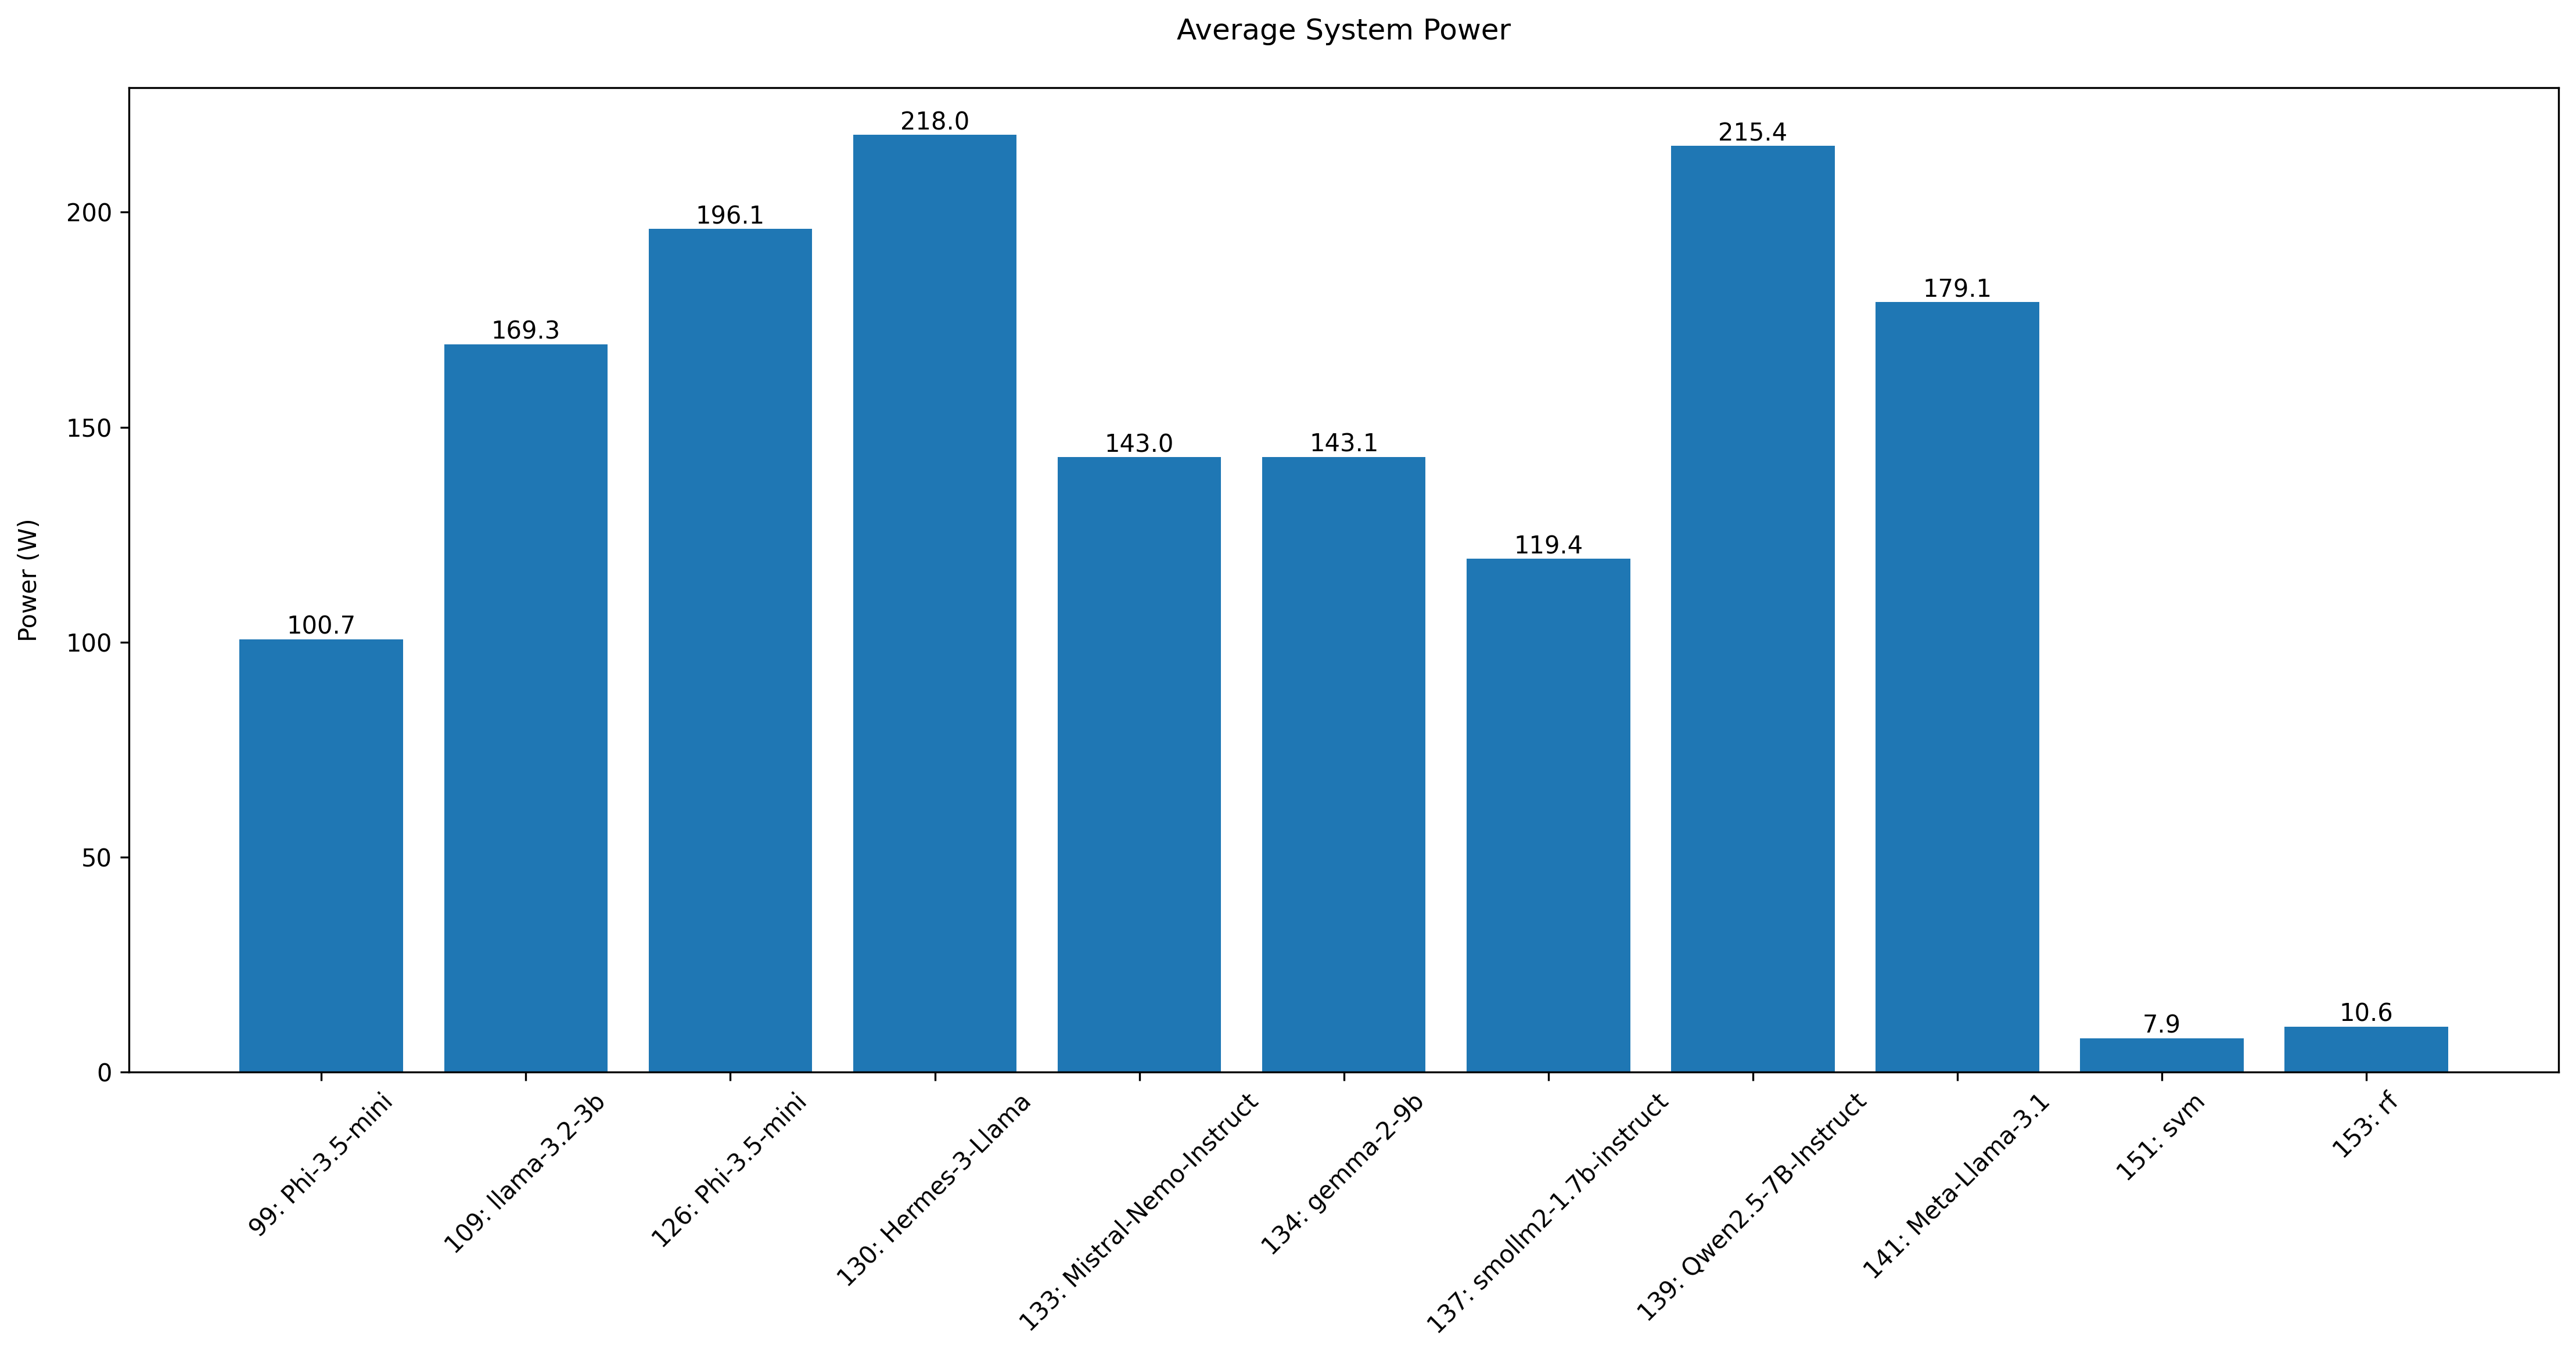

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

# Set figure parameters for better spacing
plt.rcParams['figure.figsize'] = (15, 8)  # Larger figure size
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.constrained_layout.h_pad'] = 0.4
plt.rcParams['figure.constrained_layout.w_pad'] = 0.4

# List of run IDs and data collection
run_ids = [99, 109, 126, 130, 133, 134, 137, 139, 141, 151, 153]
model_stats = {}
for run_id in run_ids:
    run = Run.get(id=run_id)
    model_stats[run.formatted_name()] = run.get_power_stats_df()

# 1. Component Energy Bar Plot
plt.figure(dpi=300)
component_df = pd.DataFrame([
    {'Model': model, 'Component': row['Component'], 'Total Energy (kJ)': row['Total Energy (J)'] / 1000}
    for model, df in model_stats.items()
    for _, row in df[df['Component'] != 'System Total'].iterrows()
])

pivot_df = component_df.pivot(index='Component', columns='Model', values='Total Energy (kJ)')
x = np.arange(len(pivot_df.index))
width = 0.8 / len(pivot_df.columns)

for i, (model, data) in enumerate(pivot_df.items()):
    bars = plt.bar(x + i * width, data, width, label=model)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')

plt.title('Total Energy Usage by Component', pad=20)
plt.ylabel('Energy (kJ)', labelpad=10)
plt.xlabel('Component', labelpad=10)
plt.xticks(x + width * (len(pivot_df.columns) - 1) / 2, pivot_df.index, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(pad=1.5)
plt.show()

# 2. System Total Bar Plot
plt.figure(dpi=300)
system_df = pd.DataFrame([
    {'Model': model, 
     'Total Energy (kJ)': df[df['Component'] == 'System Total']['Total Energy (J)'].iloc[0] / 1000,
     'Average Power (W)': df[df['Component'] == 'System Total']['Average Power (W)'].iloc[0]}
    for model, df in model_stats.items()
])

bars = plt.bar(system_df['Model'], system_df['Total Energy (kJ)'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom')

plt.title('Total System Energy', pad=20)
plt.ylabel('Energy (kJ)', labelpad=10)
plt.xticks(rotation=45)
plt.tight_layout(pad=1.5)
plt.show()

# 3. Energy Distribution Plot
plt.figure(dpi=300)
distribution_df = pd.DataFrame([
    {'Model': model, 'Component': row['Component'], 'Percentage': row['Energy Percentage (%)']}
    for model, df in model_stats.items()
    for _, row in df[df['Component'] != 'System Total'].iterrows()
])

pivot_df = distribution_df.pivot(index='Model', columns='Component', values='Percentage')
left = np.zeros(len(pivot_df))

for i, component in enumerate(pivot_df.columns):
    bars = plt.barh(np.arange(len(pivot_df)), pivot_df[component], left=left, label=component)
    for idx, bar in enumerate(bars):
        width = bar.get_width()
        if width > 5:
            plt.text(left[idx] + width/2,
                    idx,
                    f'{width:.1f}%',
                    ha='center', va='center')
    left += pivot_df[component]

plt.title('Energy Distribution (%)', pad=20)
plt.xlabel('Energy Percentage (%)', labelpad=10)
plt.ylabel('Model', labelpad=10)
plt.yticks(np.arange(len(pivot_df)), pivot_df.index)
plt.legend(title='Component', bbox_to_anchor=(1.05, 1))
plt.tight_layout(pad=1.5)
plt.show()

# 4. Average Power Plot
plt.figure(dpi=300)
bars = plt.bar(system_df['Model'], system_df['Average Power (W)'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom')

plt.title('Average System Power', pad=20)
plt.ylabel('Power (W)', labelpad=10)
plt.xticks(rotation=45)
plt.tight_layout(pad=1.5)
plt.show()

/tmp/ipykernel_115900/4259552267.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=labels, patch_artist=True, vert=False,
/tmp/ipykernel_115900/4259552267.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


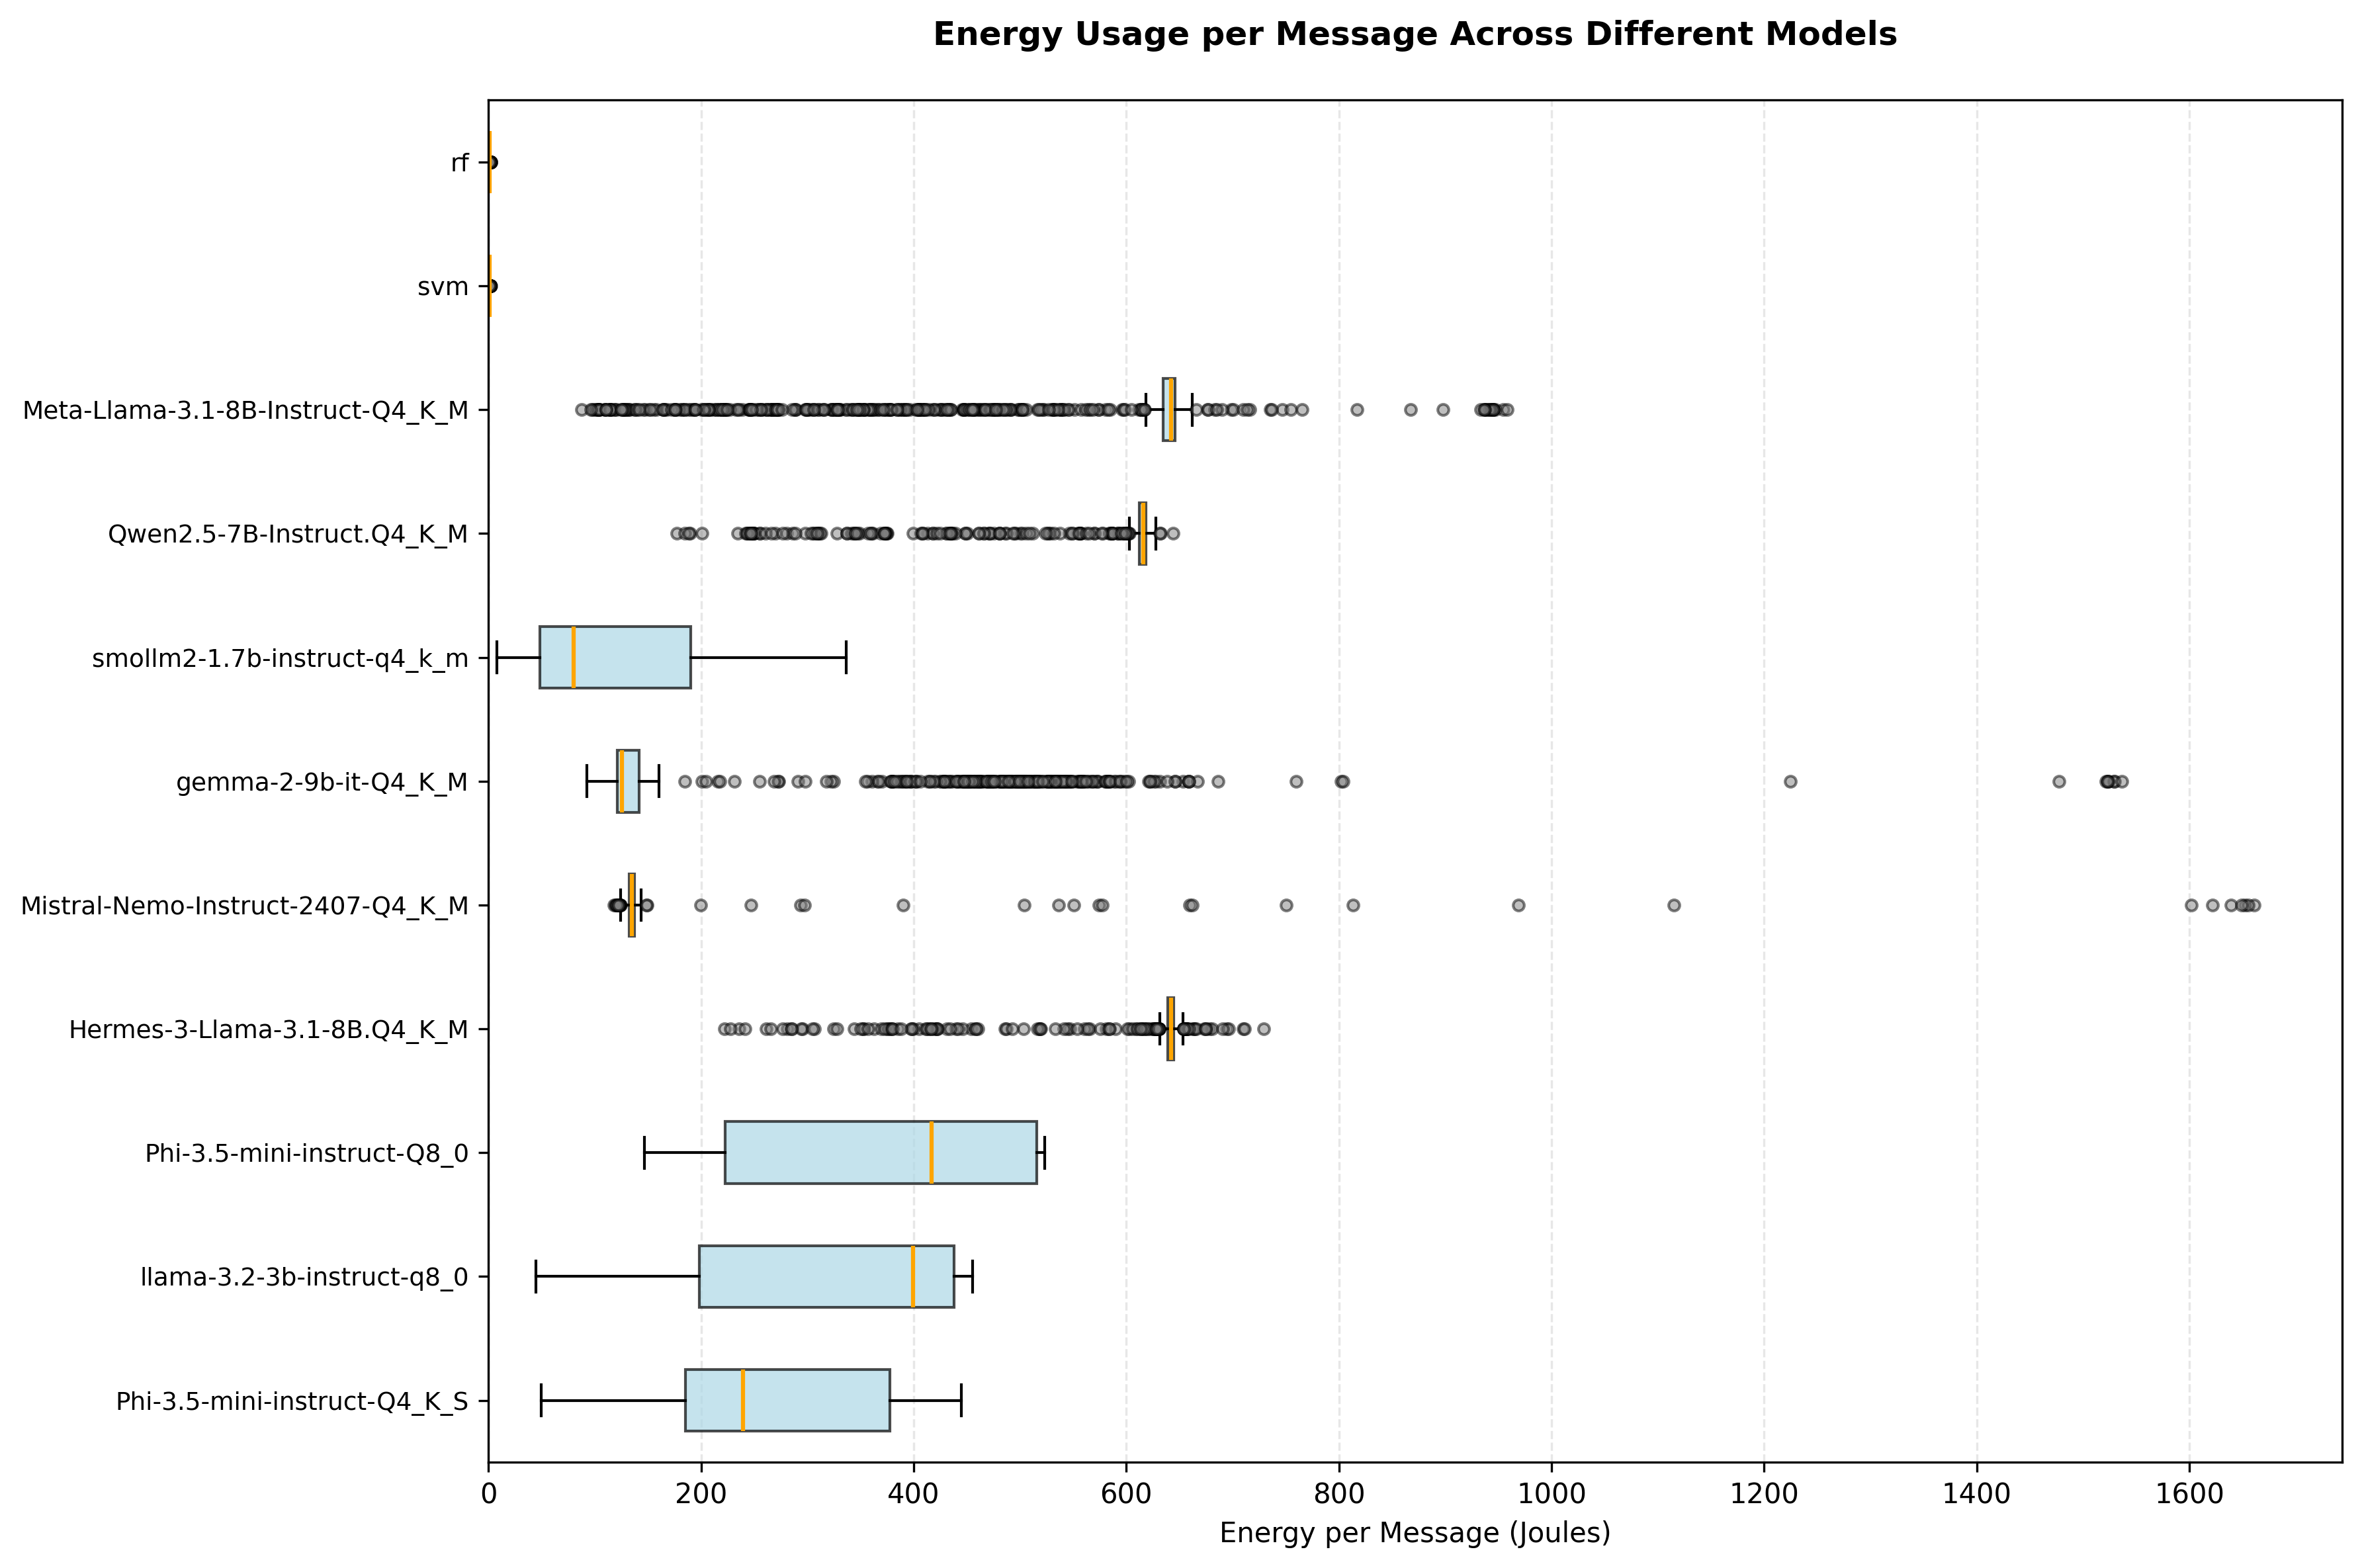


Summary Statistics:

Phi-3.5-mini-instruct-Q4_K_S:
  Mean: 266.06 J
  Median: 239.45 J
  Std Dev: 89.80 J
  Sample Size: 2337

llama-3.2-3b-instruct-q8_0:
  Mean: 318.58 J
  Median: 399.54 J
  Std Dev: 137.77 J
  Sample Size: 1681

Phi-3.5-mini-instruct-Q8_0:
  Mean: 378.28 J
  Median: 417.01 J
  Std Dev: 142.05 J
  Sample Size: 1687

Hermes-3-Llama-3.1-8B.Q4_K_M:
  Mean: 632.32 J
  Median: 642.08 J
  Std Dev: 51.45 J
  Sample Size: 1683

Mistral-Nemo-Instruct-2407-Q4_K_M:
  Mean: 144.80 J
  Median: 134.74 J
  Std Dev: 108.23 J
  Sample Size: 1687

gemma-2-9b-it-Q4_K_M:
  Mean: 193.05 J
  Median: 125.30 J
  Std Dev: 170.29 J
  Sample Size: 1685

smollm2-1.7b-instruct-q4_k_m:
  Mean: 117.67 J
  Median: 79.89 J
  Std Dev: 85.80 J
  Sample Size: 1002

Qwen2.5-7B-Instruct.Q4_K_M:
  Mean: 600.41 J
  Median: 615.74 J
  Std Dev: 63.70 J
  Sample Size: 1682

Meta-Llama-3.1-8B-Instruct-Q4_K_M:
  Mean: 588.25 J
  Median: 642.31 J
  Std Dev: 139.93 J
  Sample Size: 1680

svm:
  Mean: 0.83 J
  Me

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# List of run IDs and data collection
#run_ids = [99, 109, 126, 130, 133, 134, 137, 139, 141]
model_stats = {}

# Collect energy data for each run
for run_id in run_ids:
    run = Run.get(id=run_id)
    messages = run.get_messages()
    
    # Calculate total energy per message
    energy_per_message = []
    for msg in messages:
        total_energy = msg.cpu_usage + (msg.gpu_usage if msg.gpu_usage is not None else 0)
        energy_per_message.append(total_energy)
    
    # Use simplified model name
    model_name = run.model_name.split(".gguf")[0]
    if model_name not in model_stats:
        model_stats[model_name] = []
    model_stats[model_name].extend(energy_per_message)

# Create figure with higher DPI
plt.figure(figsize=(12, 8), dpi=300)

# Prepare data for boxplot
data = [values for values in model_stats.values()]
labels = list(model_stats.keys())

# Create horizontal boxplot with customization
bp = plt.boxplot(data, labels=labels, patch_artist=True, vert=False,
                medianprops=dict(color="orange", linewidth=1.5),
                flierprops=dict(marker='o', markerfacecolor='gray', 
                              markersize=4, alpha=0.5),
                boxprops=dict(facecolor='lightblue', alpha=0.7))

# Customize plot
plt.title('Energy Usage per Message Across Different Models', 
          pad=20, fontsize=12, fontweight='bold')
plt.xlabel('Energy per Message (Joules)', fontsize=10)

# Set y-axis labels with smaller font
plt.yticks(range(1, len(labels) + 1), labels, fontsize=9)

# Add grid for easier reading
plt.grid(True, axis='x', linestyle='--', alpha=0.3)

# Set x-axis to start at 0
plt.xlim(left=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for model, values in model_stats.items():
    stats = {
        'mean': np.mean(values),
        'median': np.median(values),
        'std': np.std(values),
        'count': len(values)
    }
    print(f"\n{model}:")
    print(f"  Mean: {stats['mean']:.2f} J")
    print(f"  Median: {stats['median']:.2f} J")
    print(f"  Std Dev: {stats['std']:.2f} J")
    print(f"  Sample Size: {stats['count']}")

/tmp/ipykernel_115900/1591738677.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


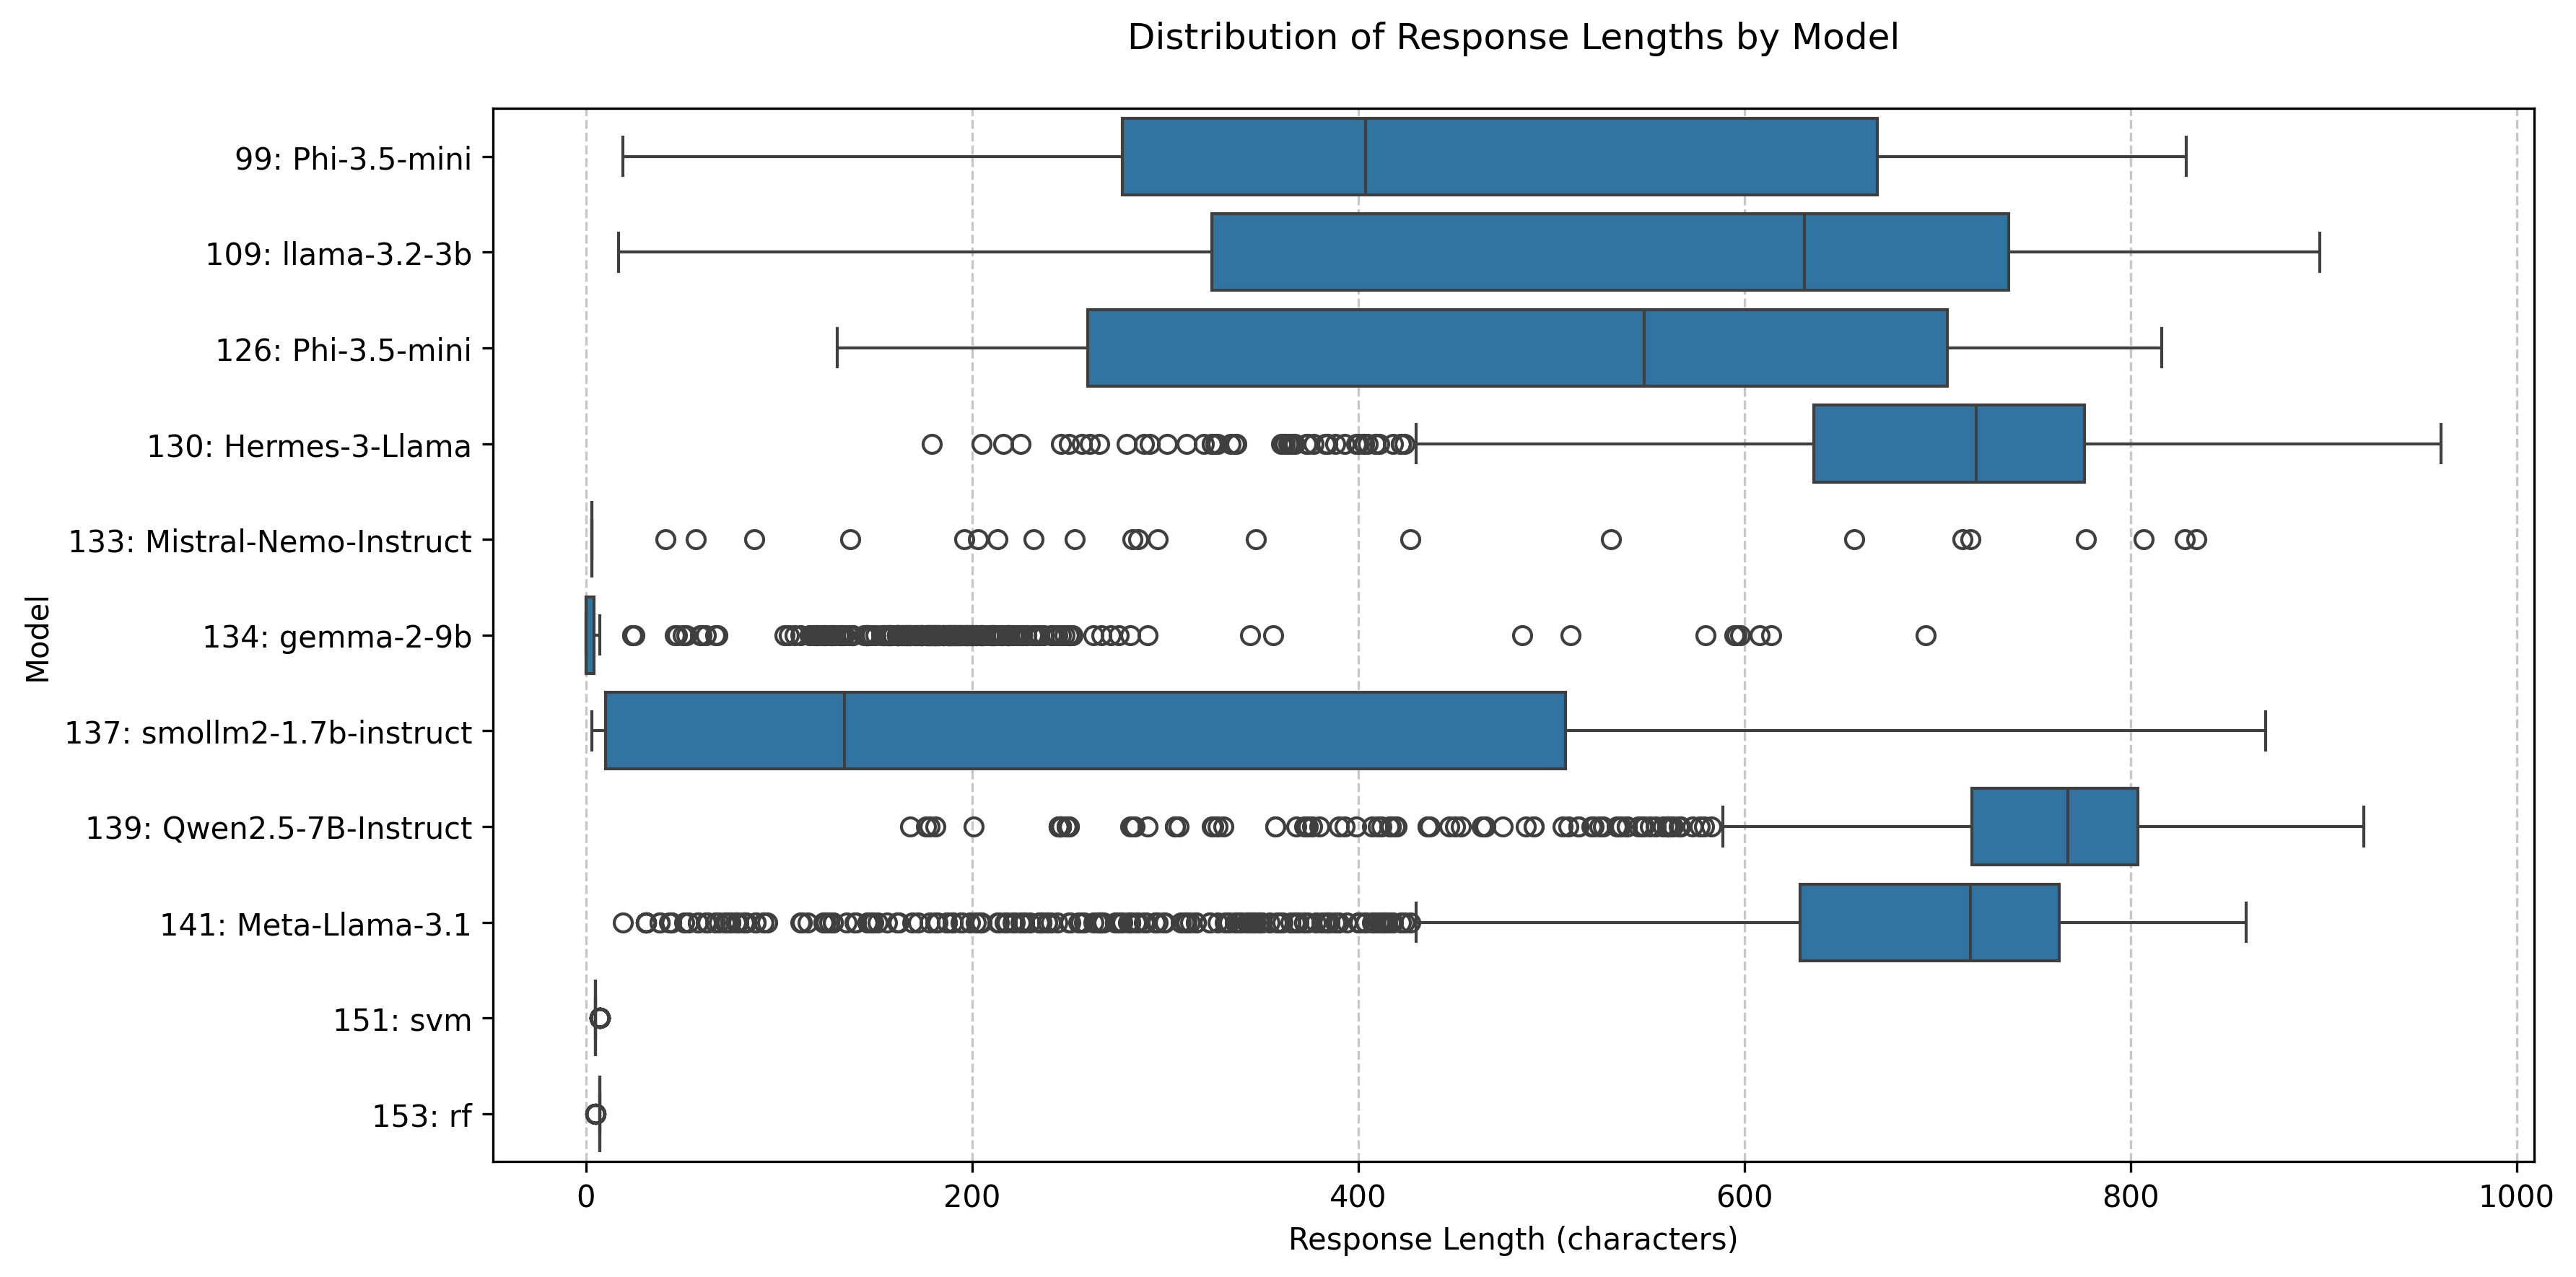


Summary Statistics:
                             count   mean    std    min    25%    50%    75%  \
Model                                                                          
109: llama-3.2-3b           1681.0  527.9  255.3   17.0  324.0  631.0  737.0   
126: Phi-3.5-mini           1687.0  495.9  218.6  130.0  260.0  548.0  705.0   
130: Hermes-3-Llama         1683.0  697.1  117.0  179.0  636.0  720.0  776.0   
133: Mistral-Nemo-Instruct  1687.0    8.2   55.0    3.0    3.0    3.0    3.0   
134: gemma-2-9b             1685.0   33.2   79.4    0.0    0.0    0.0    4.0   
137: smollm2-1.7b-instruct  1002.0  265.9  272.2    3.0   10.0  134.0  507.5   
139: Qwen2.5-7B-Instruct    1682.0  744.7  104.0  168.0  718.0  767.5  804.0   
141: Meta-Llama-3.1         1680.0  652.8  179.1   19.0  629.0  717.0  763.2   
151: svm                    1687.0    5.1    0.4    5.0    5.0    5.0    5.0   
153: rf                     1687.0    7.0    0.2    5.0    7.0    7.0    7.0   
99: Phi-3.5-mini   

In [6]:
# Import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Dict, List
import numpy as np


# Create a dictionary to store response lengths for each model
model_responses: Dict[str, List[int]] = {}

# Collect response lengths for each model
for run_id in run_ids:
    run = Run.get(run_id)
    if run is None:
        print(f"Warning: Run {run_id} not found")
        continue
        
    model_name = run.formatted_name()  # Use the formatted model name
    
    # Get messages for this run
    messages = run.get_messages()
    
    # Calculate response lengths
    response_lengths = [len(msg.response) for msg in messages]
    
    # Add to dictionary
    if model_name not in model_responses:
        model_responses[model_name] = []
    model_responses[model_name].extend(response_lengths)

# Convert to DataFrame for plotting
plot_data = []
for model, lengths in model_responses.items():
    for length in lengths:
        plot_data.append({
            'Model': model,
            'Length': length
        })

df = pd.DataFrame(plot_data)

# Create the horizontal boxplot
plt.figure(figsize=(12, 6), dpi=300)

# Create boxplot using seaborn for better styling
sns.boxplot(data=df, 
            x='Length',
            y='Model',
            orient='h',
            whis=1.5)  # 1.5 IQR for whiskers

# Customize the plot
plt.title('Distribution of Response Lengths by Model', pad=20)
plt.xlabel('Response Length (characters)')
plt.ylabel('Model')

# Add grid for better readability
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Add statistical annotations
for i, model in enumerate(df['Model'].unique()):
    model_data = df[df['Model'] == model]['Length']
    
    # Calculate statistics
    median = model_data.median()
    mean = model_data.mean()
    count = len(model_data)

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
stats_df = df.groupby('Model')['Length'].describe()
print(stats_df.round(1))  # Round to 1 decimal place for readability